In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchsummary import summary

import numpy as np
import datetime
import os, sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

from tqdm import tqdm
import glob
from PIL import Image

### **Google Drive linking and other operations for saving some data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
PATH_DRIVE = '/content/drive/My Drive/UNIMORE/DCGAN' # Path on Google Drive where to save data (trained models and generation samples)

Mounted at /content/drive


In [3]:
verbose = False
torch.manual_seed(1)
NOISE_VECTOR_DIM = 100
MODEL_NAME = 'DeepConvolutionalGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(PATH_DRIVE + '/samples'):
  os.makedirs(PATH_DRIVE + '/samples')

if not os.path.exists(PATH_DRIVE + '/samples/gif_dir'):
  os.makedirs(PATH_DRIVE + '/samples/gif_dir')

if not os.path.exists(PATH_DRIVE + '/training_models'):
  os.makedirs(PATH_DRIVE + '/training_models')

if not os.path.exists(PATH_DRIVE + '/training_models/Discriminator'):
  os.makedirs(PATH_DRIVE + '/training_models/Discriminator')

if not os.path.exists(PATH_DRIVE + '/training_models/Generator'):
  os.makedirs(PATH_DRIVE + '/training_models/Generator')

if not os.path.exists('dataset'):
  os.makedirs('dataset')

In [ ]:
dataset_path = PATH_DRIVE + "/anime_dataset/archive.zip"
print(dataset_path)
!unzip '/content/drive/My Drive/UNIMORE/DCGAN/anime_dataset/archive.zip' -d 'dataset/'  #unzipping dataset

# **Project start**

In [15]:
def show_images(images, column=5, fig_size=(5, 5)):
  '''
  Function used to plot images (input as a batch).
  - column parameter is for choose the layout of plot.
  - fig_size is used for select the size (n x m) of the single batch's images
  '''
  images = images / 2 + 0.5
  fig, ax = plt.subplots(figsize=fig_size)
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(images.detach(), nrow=column).permute(1, 2, 0))


def show_batch(dl, column=22, fig_size=(5, 5)):
  '''
  Show sample images of first dataset's batch.
  '''
  for images, _ in dl:
    show_images(images, column, fig_size)
    break


def make_gif(frame_folder, duration):
  '''
  Make a gif from generated samples during the training in order to see
  the improvement of the generator.

  returns:
    save a gif on google drive directory
  '''
  step = 500
  a = [image for image in glob.glob(f"{frame_folder}/*.jpg")]
  imgs = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.jpg")]
  for i in range(len(imgs)):
    plt.imshow(imgs[i], cmap='gray')
    plt.axis('off')
    plt.title('step: {}'.format(int(step*i)))
    plt.savefig(frame_folder + 'gif_dir/img_%d.jpg' % int(step*i))


  a = [image for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  frames = [Image.open(image) for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  print('frames: {}'.format(len(frames)))
  frame_one = frames[0]
  frame_one.save(PATH_DRIVE + "/training_improvements.gif", format="GIF",
              append_images=frames, save_all=True, duration=duration, loop=0)

### **Dataset loading and preparation**

In [ ]:
BATCH_SIZE = 64
train_transform = transforms.Compose([transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_dataset = datasets.ImageFolder(root='dataset', transform=train_transform)
data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

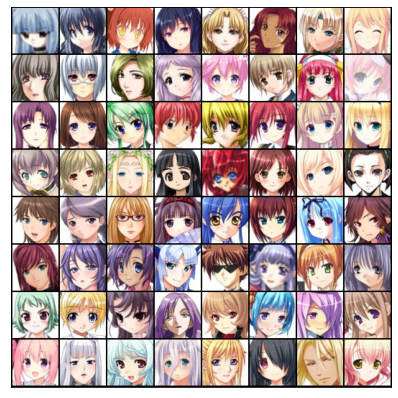

In [ ]:
show_batch(data_loader, column=8, fig_size=(7,7))

**Generator network summary**
Note:
- We start with 512 output channels, and divide the output channels by a factor of 2 up until the 4th block,
- In the final block, the output channels equal to 3 (RGB image).
- The stride of 2 is used in every layer. It doubles the input at every block, going from 4 x 4 at the first block, to 64 x 64 at the final block. 
- The tanh activation at the output layer ensures that the pixel values are mapped between (-1, 1).  If you recall, we normalized the images to range [-1, 1] ) for the output of the tanh function also lies between (-1, 1).

In [ ]:
# Generator Model Class Definition      
class Generator(nn.Module):
  '''
  Generator model definition.
  In the Deep Convolutional GAN it is defined as an CNN model with input size 
  equal to noise vector.
  The output size is the same as images we want to generate
  (in this case is 3 x 64 x 64).
  The model has been divided into 5 blocks, and each block consists of:
    - A Convolution 2D Transpose Layer
    - Followed by a BatchNorm Layer and LeakyReLU Activation Function
    - A tanh Activation Function in the last block, instead of ReLU. 
  '''
  def __init__(self, input_size=NOISE_VECTOR_DIM):
    super(Generator, self).__init__()
    
    self.model = nn.Sequential(
      # Block 1:input is Z, going into a convolution
      nn.ConvTranspose2d(input_size, 64 * 8, 4, 1, 0, bias=False),
      nn.BatchNorm2d(64 * 8),
      nn.LeakyReLU(0.2),

      # Block 2: (64 * 8) x 4 x 4
      nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(64 * 4),
      nn.LeakyReLU(0.2),

      # Block 3: (64 * 4) x 8 x 8
      nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(64 * 2),
      nn.LeakyReLU(0.2),

      # Block 4: (64 * 2) x 16 x 16
      nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.2),

      # Block 5: (64) x 32 x 32
      nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
      nn.Tanh()
      # Output: (3) x 64 x 64
  )

  def forward(self, noise_vector):
    generated_img = self.model(noise_vector)
    return generated_img

**Discriminator network summary**
- The first block consists of a convolution layer, followed by an activation function.
- Blocks 2, 3, and 4 consist of a convolution layer, followed by a batch-normalization layer and an activation function, LeakyReLU. 
- The last block comprises no batch-normalization layer, with a sigmoid activation function. 

You start with 64 filters in each block, then double them up till the 4th block. And finally, are left with just 1 filter in the last block.

In [ ]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
  '''
  Discriminator model definition as a binary classifier.
  In the Deep Convolutional GAN it is defined as an CNN model with input size equal to
  flattened image size.
  The output size is the 1 (i.e. the probability of a binary problem -> real or fake).
  '''
  def __init__(self, img_size=64, output_size=1):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      # Block 1: (3) x 64 x 64
      nn.Conv2d(3, img_size, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, inplace=True),

      # Block 2: (64) x 32 x 32
      nn.Conv2d(img_size, img_size * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(img_size * 2),
      nn.LeakyReLU(0.2, inplace=True),

      # Block 3: (64*2) x 16 x 16
      nn.Conv2d(img_size * 2, img_size * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(img_size * 4),
      nn.LeakyReLU(0.2, inplace=True),

      # Block 4: (64*4) x 8 x 8
      nn.Conv2d(img_size * 4, img_size * 8, 4, 2, 1, bias=False),
      nn.BatchNorm2d(img_size * 8),
      nn.LeakyReLU(0.2, inplace=True),

      # Block 5: (64*8) x 4 x 4
      nn.Conv2d(img_size * 8, output_size, 4, 1, 0, bias=False),
      nn.Sigmoid(),
      nn.Flatten()
      # Output: 1
  )

  def forward(self, input):
      output = self.model(input)
      return output

## **Training phase**

In [ ]:
#Models creation
num_samples = 100
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

#Loss function
adversarial_loss  = nn.BCELoss()

#Optimizer
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
max_epoch = 30 # epochs for training
step = 0
step_frequency = 500 #frequency to save training samples in order to see G's improvements
n_critic = 1 # for training more k steps about Discriminator

D_loss_history = []
G_loss_history = []

D_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to fake

for epoch in tqdm(range(max_epoch), desc='DCGAN training'): 
  # D_loss_list, G_loss_list = [], []
  for index, (real_images, _) in enumerate(data_loader):
    # training D
    x = real_images.to(DEVICE)
    x_outputs = D(x)
    D_x_loss = adversarial_loss(x_outputs, D_labels)

    z = torch.randn(BATCH_SIZE, NOISE_VECTOR_DIM, 1, 1).to(DEVICE)
    generated_image = G(z)
    z_outputs = D(generated_image)
    D_z_loss = adversarial_loss(z_outputs, D_fakes)
    D_loss = D_x_loss + D_z_loss


    D.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    if step % n_critic == 0:
      # Training Generator
      z = torch.randn(BATCH_SIZE, NOISE_VECTOR_DIM, 1, 1).to(DEVICE)
      z_outputs = D(G(z))
      G_loss = adversarial_loss(z_outputs, D_labels)

      G.zero_grad()
      G_loss.backward()
      G_optimizer.step()


    if verbose:
      if step % 500 == 0:
        print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

    
    if step % step_frequency == 0:
      G.eval()
      # img = get_sample_images(G, num_samples)
      # imsave(PATH_DRIVE + '/samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), generated_image.data[:50], cmap='gray')
      save_image(generated_image.data[:25], PATH_DRIVE + '/samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), nrow=5, normalize=True)
      G.train()

    step += 1
    # print(step)

  D_loss_history.append(D_loss.item())
  G_loss_history.append(G_loss.item())
    
  torch.save(G.state_dict(), PATH_DRIVE + '/training_models/Generator/G_epoch_%d.pth' % (epoch))
  torch.save(D.state_dict(), PATH_DRIVE + '/training_models/Discriminator/D_epoch_%d.pth' % (epoch))

DCGAN training: 100%|██████████| 30/30 [1:03:15<00:00, 126.51s/it]


## **Post training operations**

### **Plotting Generator and Discriminator's losses**

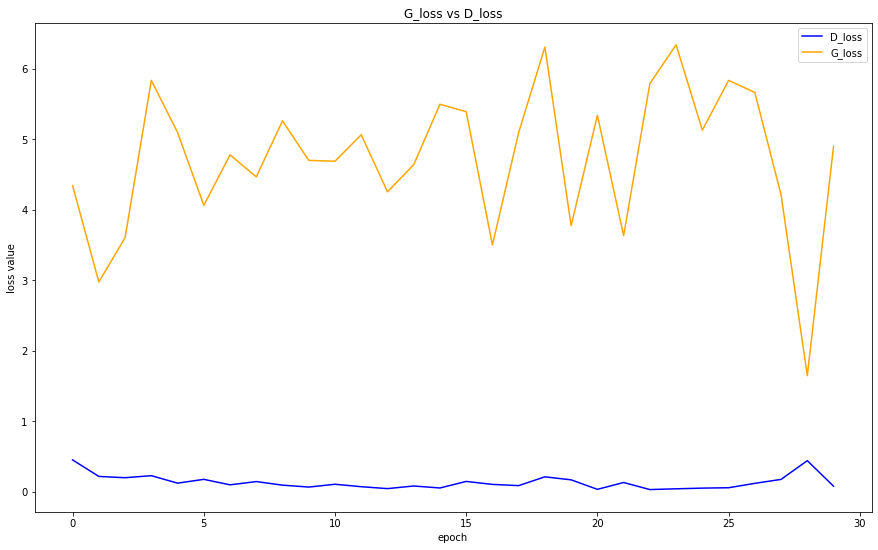

In [ ]:
plt.figure(figsize=(15,9)) 
plt.plot(D_loss_history, color='blue', label='D_loss') #plot the data
plt.plot(G_loss_history, color='orange', label='G_loss') #plot the data
plt.ylabel('loss value') #set the label for y axis
plt.xlabel('epoch') #set the label for x-axis
plt.title("G_loss vs D_loss") #set the title of the graph
plt.legend()
plt.show() #display the graph

### **Plotting some sample images**

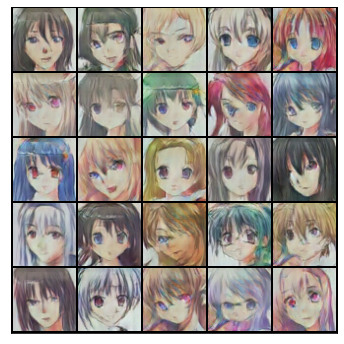

In [ ]:
# generation to image
G.eval()
z = torch.randn(25, NOISE_VECTOR_DIM, 1, 1).to(DEVICE)
generated_image = G(z)
show_images(generated_image.cpu(), column=5, fig_size=(6,6))

In [ ]:
# Saving params
min_value = min(G_loss_history)
min_index = G_loss_history.index(min_value)
print(min_index)  #to see at which epoch the Generator has te lowest loss

# Saving models at last epoch of training
torch.save(D.state_dict(), PATH_DRIVE + '/training_models/Discriminator/Discriminator.pth')
torch.save(G.state_dict(), PATH_DRIVE + '/training_models/Generator/Generator.pth')

28


### **Loading model using pytorch**

In [ ]:
G.load_state_dict(torch.load(PATH_DRIVE + '/training_models/Generator/G_epoch_28.pth'), strict=False)
G.eval()

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), paddin

#### **Model summary**

In [ ]:
summary(G, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        LeakyReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

### **Making a gif to see Generator's improvement during training**

frames: 59


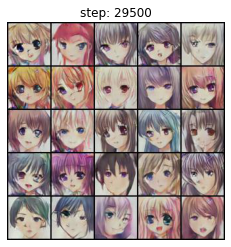

In [17]:
make_gif(PATH_DRIVE + '/samples/', 400)